# CBTN learning lab for multi-modal imaging
#### October 10, 2024

This notebook illustrates how to run an unsupervised machine learning analysis on Flywheel using processed tabular data.

Based on: [Haldar et al. 2023 Neoplasia](https://pubmed.ncbi.nlm.nih.gov/36566592/)

In [337]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

random_state = 1

In [338]:
# load clinical and molecular features
molec_df = pd.read_csv('molec_features.csv')

# load radiomic features
rad_df = pd.read_csv('radiomic_features.csv')

# filter to only subjects with molec & radiomic data
X = molec_df.merge(rad_df, how='left', on='SubjectID')
y = X[['OpenPedCan Molecular Subtype']]
X = X.drop(columns='OpenPedCan Molecular Subtype')


In [339]:
# pre-process the radiomic features
X_radiomic = X.copy()
X_radiomic = X_radiomic.set_index('SubjectID')

# apply imputing
X_radiomic = X_radiomic.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer()
imputer.fit(X_radiomic)
X_radiomic.iloc[:, :] = imputer.transform(X_radiomic)

# apply standardization
scaling = StandardScaler()
scaling.fit(X_radiomic)
X_radiomic.iloc[:, :] = scaling.transform(X_radiomic)


In [340]:
print(f'N subjects: {X_radiomic.shape[0]}')
print(f'N radiomic features: {X_radiomic.shape[1]}')


N subjects: 192
N radiomic features: 929


In [341]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.9, random_state=random_state) # Choose the number of components you want to keep
pca_data = pca.fit_transform(X_radiomic)


In [342]:

print(f'N principal components: {pca_data.shape[1]}')


N principal components: 51


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



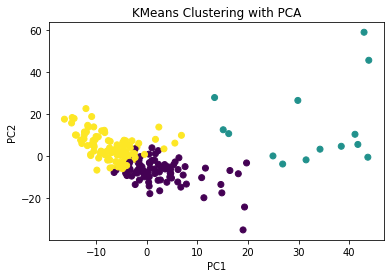

In [343]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Using K-Means as an example
# n_unique_subtypes = len(y['OpenPedCan Molecular Subtype'].unique().tolist())
# kmeans = KMeans(n_clusters=n_unique_subtypes) # Choose the number of clusters you want
kmeans = KMeans(n_clusters=3, random_state=random_state) # Choose the number of clusters you want

kmeans.fit(pca_data)
labels = kmeans.labels_ 

# Add labels to the dataframe
X = X_radiomic
X['cluster'] = labels

# Visualize the clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
plt.title('KMeans Clustering with PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


<Axes: xlabel='Molecular Subtype'>

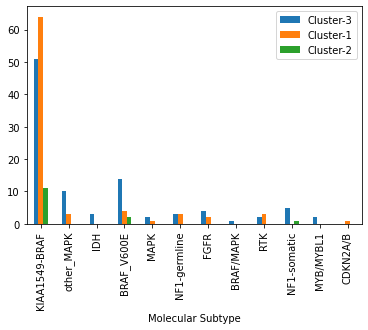

In [344]:
if 'SubjectID' not in X.columns.tolist():
    X = X.reset_index(drop=False)

k_clusters = X[['SubjectID','cluster']]
df = k_clusters.merge(molec_df)

unique_clusters = df['cluster'].unique().tolist()
unique_subtypes = df['OpenPedCan Molecular Subtype'].unique().tolist()
results=[]
for subtype_ in unique_subtypes:
    subtype_info = [subtype_]
    cluster_labels = []
    for cluster_ in unique_clusters:
        cluster_count = len(df[(df['OpenPedCan Molecular Subtype']==subtype_) & (df['cluster']==cluster_)])
        subtype_info = subtype_info + [cluster_count]
        cluster_labels.append(f'Cluster-{cluster_+1}')
    results.append(subtype_info)

cols = ['Molecular Subtype'] + cluster_labels
plot_df = pd.DataFrame(results, columns=cols)

plot_df.plot.bar(x='Molecular Subtype', y=cluster_labels) 


In [345]:
from scipy.stats import f_oneway

# Group data by condition
grouped_data = [df[df['OpenPedCan Molecular Subtype'] == cond]['cluster'] for cond in df['OpenPedCan Molecular Subtype'].unique()]

# Perform ANOVA
f_statistic, p_value = f_oneway(*grouped_data)

print('F-statistic:', f_statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print('There is a significant effect of molecular subtype on cluster assignments.')
else:
    print('There is no significant effect of molecular subtype on cluster assignments.')

F-statistic: 2.2246894808469766
p-value: 0.014968998373574493
There is a significant effect of molecular subtype on cluster assignments.


In [346]:
import joblib

# save trained models to disk
joblib.dump(pca, 'pca_model.joblib')
joblib.dump(kmeans, 'kmeans_model.joblib')


['kmeans_model.joblib']